# Notebook 4: Análisis Espectro-Temporal de EEG mediante STFT y Espectrogramas

**Materias relacionadas:** Instrumentación Biomédica, Electrofisiología, Procesamiento Digital de Señales, Temas Selectos en Biomatemáticas y Temas Selectos en Biofísica.  
**Antecedentes:** Notebook 1, Notebook 2 y Notebook 3.  
**Objetivo:** Comprender la Transformada de Fourier de Tiempo Corto (STFT) y su aplicación en la construcción e interpretación de espectrogramas para el análisis espectro-temporal de señales EEG.

## 4.1 Introducción

Los métodos espectrales clásicos, como la **Transformada Rápida de Fourier (FFT)** y la **Densidad Espectral de Potencia (PSD)**, proporcionan información sobre la composición frecuencial de una señal, pero no permiten conocer **en qué momento del tiempo** ocurren los eventos que generan dichos componentes. Esta limitación es importante en el caso del EEG, donde los ritmos cerebrales cambian de manera dinámica a lo largo del tiempo debido a la naturaleza no estacionaria del sistema nervioso central (Cohen, 2014).

En contextos clínicos y experimentales, la información temporal del contenido espectral es esencial para analizar fenómenos como:

- **Transitorios espectrales**, donde aparecen oscilaciones breves asociadas con estímulos sensoriales o tareas cognitivas.  
- **Reactividad alfa**, caracterizada por la variación de la potencia en la banda de 8–12 Hz entre condiciones de ojos abiertos (OA) y ojos cerrados (OC).  
- **Eventos patológicos**, como las descargas epileptiformes, que presentan componentes espectrales definidos pero de corta duración.  
- **Transiciones de estado**, como los cambios progresivos entre alerta, somnolencia y sueño, que alteran la distribución temporal de la energía espectral.

Para describir estos procesos, se requieren técnicas que combinen simultáneamente **resolución temporal** y **resolución frecuencial**. La **Transformada de Fourier de Tiempo Corto (Short-Time Fourier Transform, STFT)** introduce esta capacidad mediante la aplicación de la transformada de Fourier a segmentos locales de la señal definidos por una **ventana deslizante** (Allen & Rabiner, 1977; Flandrin, 1999). El resultado es una función bidimensional \( S(t,f) \) que describe cómo la energía de la señal se distribuye en el tiempo y en la frecuencia (Boashash, 2016).

El **espectrograma** es la representación visual de esta función, donde los ejes corresponden a tiempo y frecuencia, y el color o intensidad indica la potencia o amplitud del componente espectral. Su interpretación es directa: regiones de alta densidad energética reflejan actividad dominante en una frecuencia particular durante un intervalo temporal determinado.

En el ámbito del EEG, los espectrogramas permiten identificar **fluctuaciones dinámicas de energía en bandas fisiológicas** (θ: 4–7 Hz, α: 8–12 Hz, β: 13–30 Hz, γ: >30 Hz) y evaluar la relación entre los ritmos cerebrales y los procesos neuronales subyacentes (Hsu, Lin, & Hsu, 2021). Este enfoque constituye una extensión natural del análisis espectral desarrollado en los notebooks anteriores, integrando ahora la dimensión temporal de los procesos neuroeléctricos.

En este cuaderno se abordarán los fundamentos matemáticos de la STFT, la definición de sus parámetros de implementación (ventana, solapamiento y tamaño de segmento), y la aplicación práctica a señales EEG reales del canal occipital O1, con el fin de estudiar la dinámica espectro-temporal durante la transición OA/OC.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import pandas as pd
import os

# --- Parámetros generales ---
fs = 128  # Hz
canal = 6  # Canal O1
ti_abiertos, tf_abiertos = 105, 120  # Intervalo OA

# --- Ruta del archivo ---
ruta = "/Users/yann/Documents/Tesis/Datos/EEG/H24_OC_OA.csv"

# --- Carga y filtrado Butterworth (2–45 Hz) ---
datos = pd.read_csv(ruta)
lowcut, highcut = 2, 45
orden = 4
b, a = signal.butter(orden, [lowcut/(fs/2), highcut/(fs/2)], btype='bandpass')
datosfilt = signal.filtfilt(b, a, datos.to_numpy(), axis=0)
datosfilt = pd.DataFrame(datosfilt, columns=datos.columns)

## 4.2 Fundamentos matemáticos de la Transformada de Fourier de Tiempo Corto (STFT)

La **Transformada de Fourier de Tiempo Corto (STFT)** consiste en aplicar la transformada de Fourier dentro de una *ventana deslizante* $w(t)$ que selecciona fragmentos locales de la señal $x(t)$.

$$
X(t, f) = \int_{-\infty}^{\infty} x(\tau)\,w(\tau - t)\,e^{-i2\pi f \tau}\,d\tau
$$

- $x(\tau)$: señal original (en este caso, EEG filtrado).  
- $w(\tau - t)$: ventana centrada en el instante $t$.  
- $X(t,f)$: transformada compleja dependiente del tiempo y la frecuencia.  
- $|X(t,f)|^2 = S(t,f)$: **espectrograma**, que representa la energía instantánea en cada par $(t,f)$.

El **compromiso tiempo–frecuencia** surge del tamaño de la ventana $N$:  
ventanas cortas otorgan buena resolución temporal y pobre resolución espectral, y viceversa.

### Parámetros principales de la STFT (en Python)

| Parámetro | Significado | Efecto |
|:--|:--|:--|
| `fs` | Frecuencia de muestreo (Hz) | Define el rango de frecuencias visibles ($f_N = fs/2$). |
| `window` | Tipo de ventana (Hann, Hamming, Blackman) | Controla la fuga espectral y la suavidad en los bordes. |
| `nperseg` | Número de muestras por ventana | Determina la resolución temporal y espectral. |
| `noverlap` | Muestras de solapamiento entre ventanas | Suaviza las transiciones temporales. |
| `mode` | Salida (`'magnitude'`, `'power'`, `'complex'`) | Controla la magnitud devuelta por la función. |

Los resultados de la STFT se visualizan mediante el **espectrograma**,  
una representación en escala de color que muestra la densidad de potencia en el tiempo y la frecuencia (Cohen, 1995; Boashash, 2016).





In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import signal
from scipy.fft import fft, fftshift
import os.path as os
from scipy.fftpack import fft, ifft
from scipy.signal import filtfilt, butter, spectrogram, stft
from scipy.integrate import simpson
import seaborn as sns

In [3]:


# Cargar datos originales
ruta = '/Users/yann/Documents/Tesis/Datos/EEG/H24_OC_OA.csv'
datos = pd.read_csv(ruta)

# Extraer matriz de datos y definir parámetros
eeg = datos.values
fm = 128  # Frecuencia de muestreo [Hz]
t = np.arange(len(eeg)) / fm

# Parámetros del filtro Butterworth
orden = 4
fc_low = 2
fc_high = 45
Wn = [fc_low / (fm / 2), fc_high / (fm / 2)]

# Diseño del filtro paso banda
b, a = signal.butter(orden, Wn, btype='bandpass')

# Aplicación del filtro a TODAS las columnas del EEG
datosfilt = signal.filtfilt(b, a, eeg, axis=0)

print('Filtro Butterworth 2–45 Hz (orden 4) aplicado correctamente a todo el dataset EEG.')


Filtro Butterworth 2–45 Hz (orden 4) aplicado correctamente a todo el dataset EEG.




## 4.3 Fundamentos Teóricos de la STFT

### 4.3.1 Transformada de Fourier de Tiempo Corto: conceptos fundamentales

La STFT extiende el análisis de Fourier tradicional aplicando ventanas deslizantes a la señal temporal, permitiendo obtener información espectral localizada en el tiempo (Sejdić et al., 2009). Matemáticamente, la STFT de una señal x(t) se define como:

$$\text{STFT}(\tau, \omega) = \int_{-\infty}^{\infty} x(t)w(t-\tau)e^{-j\omega t}dt$$ 

donde $w(t-\tau)$ es la función ventana centrada en el tiempo $\tau$ , y $w$ representa la frecuencia angular.

### 4.3.2 Principio de incertidumbre tiempo-frecuencia

Un aspecto fundamental en el análisis espectro-temporal es el **principio de incertidumbre de Heisenberg** aplicado al procesamiento de señales (Gabor, 1946). Este principio establece que no es posible obtener simultáneamente resolución temporal y frecuencial perfectas:

$$\Delta t \cdot \Delta f \geq \frac{1}{4\pi}$$

Esta limitación implica decisiones metodológicas críticas:

- **Ventanas cortas:** Mayor resolución temporal, menor resolución frecuencial
- **Ventanas largas:** Mayor resolución frecuencial, menor resolución temporal

Para señales EEG, donde coexisten eventos rápidos (espigas epilépticas, ~50-100ms) y oscilaciones lentas (ondas delta, ~250-1000ms), es necesario optimizar estos parámetros según el fenómeno de interés (Widmann et al., 2015).

### 4.3.3 Convolución en el contexto de la STFT

La convolución es un operador matemático que transforma dos funciones, f y g, en una tercera función que representa la magnitud de la superposición de f y una versión trasladada e invertida de g. Matemáticamente se expresa como:

$$y[n] = f[n] * g[n] = \sum_{k=-\infty}^{\infty} f[k]g[n-k]$$

En el contexto de la STFT, la convolución se utiliza implícitamente cuando aplicamos la ventana deslizante a la señal. La ventana actúa como un kernel de convolución que se desplaza a lo largo de la señal, extrayendo información local tiempo-frecuencia. Esta operación posee la propiedad de conmutatividad, lo que permite implementaciones computacionalmente eficientes (Oppenheim et al., 2010).

## 4.4 STFT con Ventana de Bartlett

### 4.4.1 Ventana de Bartlett: características y aplicación en EEG

La **ventana de Bartlett** se define matemáticamente como:

$$w(n) = 1 - \left| \frac{2n}{N-1} - 1 \right|$$

donde N es la longitud de la ventana. Esta ventana ofrece características relevantes para el análisis de EEG: forma simétrica, buena concentración espectral, reducción de la distorsión por ventana y menor varianza en la estimación espectral (Harris, 1978).

Análisis STFT - Canal: EEG.O1
Período ojos abiertos: 120-150s
Longitud de señal: 3840 puntos
Longitud de ventana: 256 puntos (2.0s)


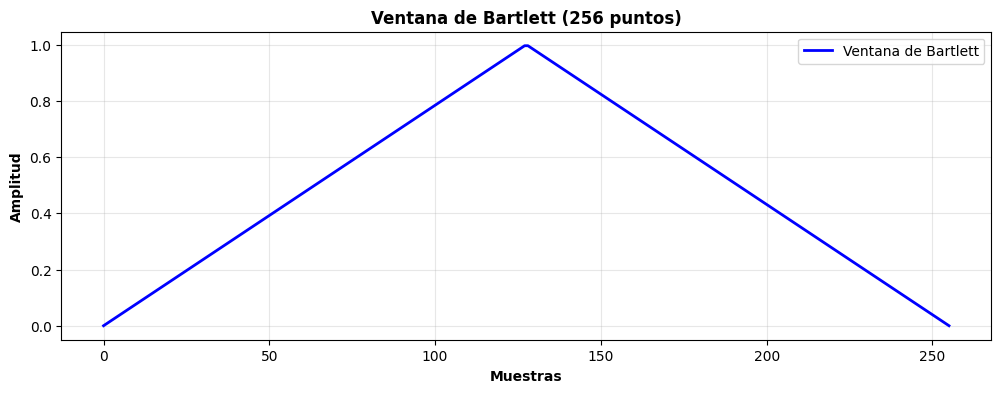

Resolución de frecuencia: 0.500 Hz


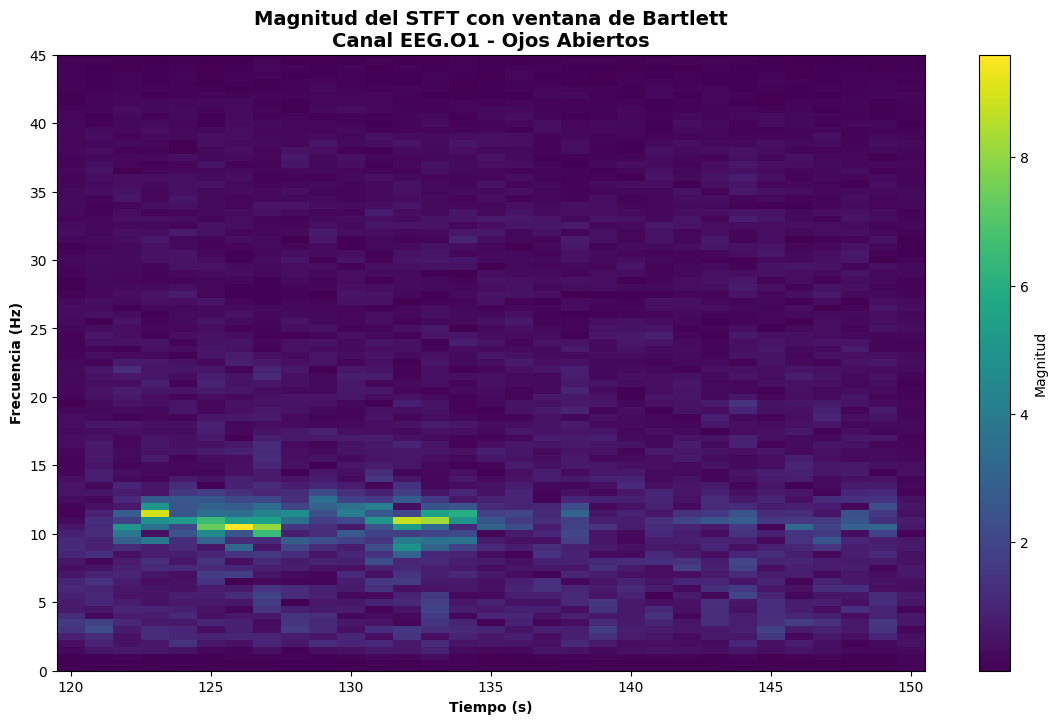

In [5]:
# Parámetros de entrada para análisis STFT
nc = 6  # Canal O1 (occipital)
ti_a = 120  # Ojos abiertos - tiempo inicio
tf_a = 150  # Ojos abiertos - tiempo final
pt_a = (tf_a - ti_a) * fm
t1_a = ti_a * fm
t2_a = tf_a * fm
t_a = np.linspace(ti_a, tf_a, pt_a)

# Datos de la señal para ojos abiertos
y_abiertos = np.array(datosfilt)[t1_a:t2_a, nc]
longitud_senal = len(y_abiertos)
longitud_ventana = 256

print(f"Análisis STFT - Canal: {nombres[nc]}")
print(f"Período ojos abiertos: {ti_a}-{tf_a}s")
print(f"Longitud de señal: {longitud_senal} puntos")
print(f"Longitud de ventana: {longitud_ventana} puntos ({longitud_ventana/fm:.1f}s)")

# Ventana de Bartlett
ventana = scipy.signal.windows.bartlett(longitud_ventana)

# Visualizar la ventana de Bartlett
plt.figure(figsize=(12, 4))
plt.plot(ventana, 'b-', linewidth=2, label='Ventana de Bartlett')
plt.xlabel('Muestras', fontweight='bold')
plt.ylabel('Amplitud', fontweight='bold')
plt.title('Ventana de Bartlett (256 puntos)', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Parámetros de superposición
superposicion = 128  # 50% de superposición
superposicion = min(longitud_ventana - 1, max(0, superposicion))

# Resolución de frecuencia
resolucion_frecuencia = fm / float(longitud_ventana)
print(f"Resolución de frecuencia: {resolucion_frecuencia:.3f} Hz")

# Calcular STFT con ventana de Bartlett
f, t, Zxx = scipy.signal.stft(y_abiertos, fs=fm, window=ventana, 
                              nperseg=longitud_ventana, noverlap=superposicion)

# Visualizar la magnitud del STFT
plt.figure(figsize=(14, 8))
plt.pcolormesh(t + ti_a, f, np.abs(Zxx), shading='auto', cmap='viridis')
plt.title('Magnitud del STFT con ventana de Bartlett\nCanal EEG.O1 - Ojos Abiertos', 
          fontweight='bold', fontsize=14)
plt.xlabel('Tiempo (s)', fontweight='bold')
plt.ylabel('Frecuencia (Hz)', fontweight='bold')
plt.colorbar(label='Magnitud')
plt.ylim(0, 45)  # Limitar a frecuencias de interés en EEG
plt.show()

### 4.4.2 Efecto de la superposición de ventanas

La superposición entre ventanas consecutivas es un parámetro crítico que afecta significativamente la calidad del análisis espectro-temporal. A mayor superposición, se obtiene mejor resolución temporal pero a costa de mayor carga computacional (Cohen, 2019).

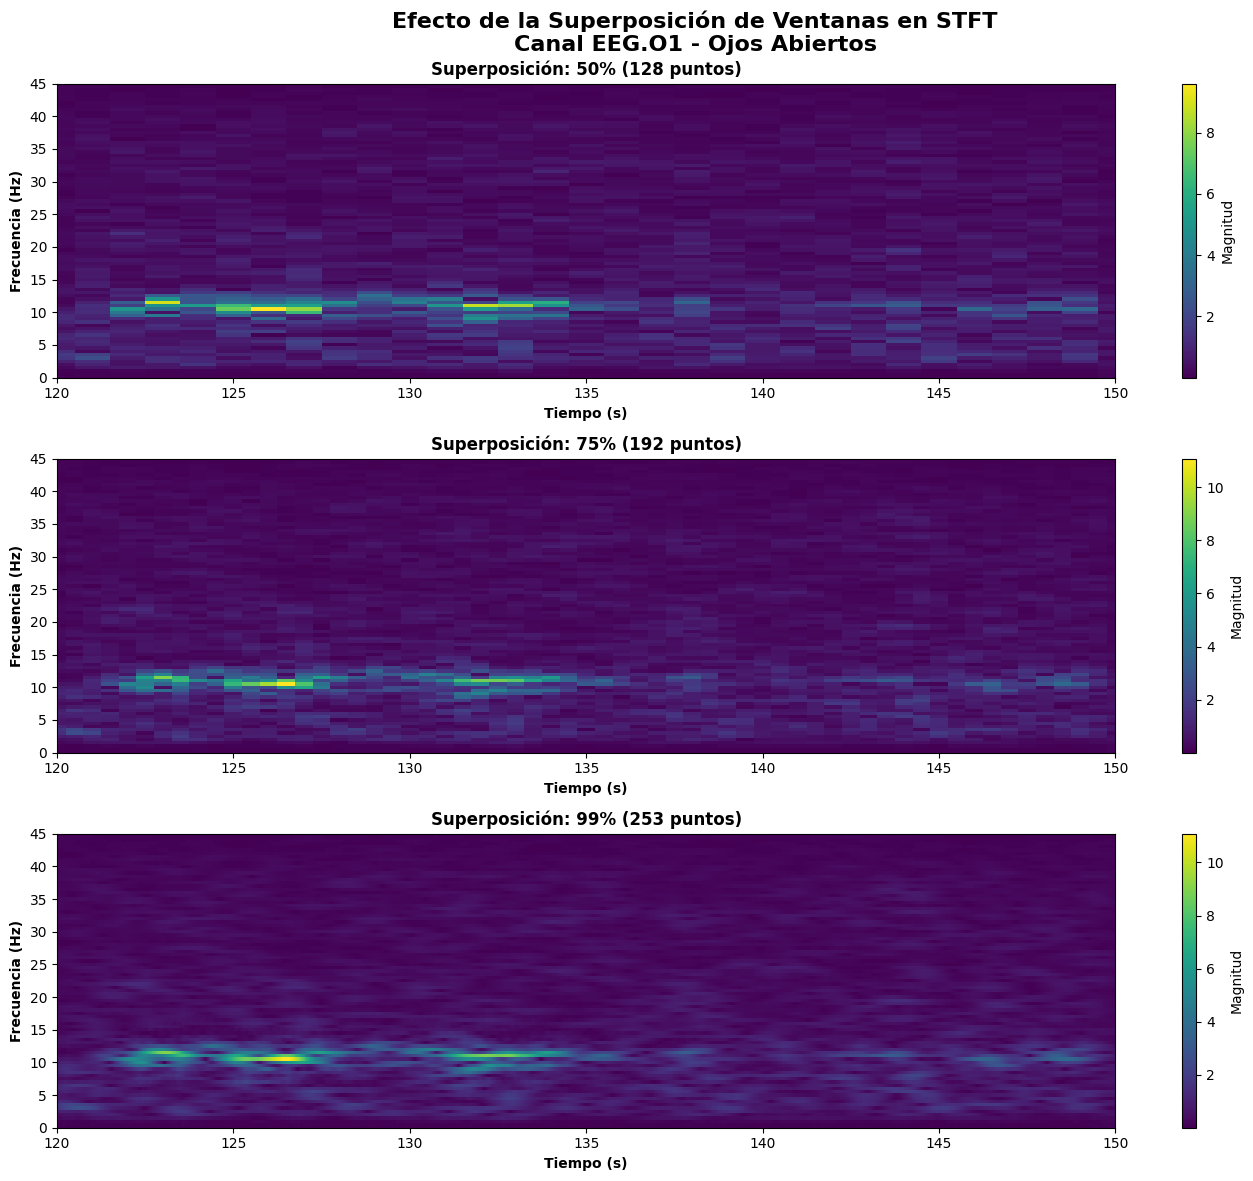

In [6]:
# Análisis del efecto de superposición
superposiciones = [0.5, 0.75, 0.99]  # 50%, 75%, 99%

# Crear figura con subplots para cada superposición
fig, axs = plt.subplots(len(superposiciones), 1, figsize=(14, 12))

for i, superposicion_pct in enumerate(superposiciones):
    # Ajustar la superposición
    noverlap = int(longitud_ventana * superposicion_pct)
    
    # Calcular STFT
    f, t, Zxx = scipy.signal.stft(y_abiertos, fs=fm, window=ventana, 
                                  nperseg=longitud_ventana, noverlap=noverlap)
    
    # Visualizar la magnitud del STFT
    im = axs[i].pcolormesh(t + ti_a, f, np.abs(Zxx), shading='auto', cmap='viridis')
    axs[i].set_title(f'Superposición: {superposicion_pct:.0%} ({noverlap} puntos)', 
                     fontweight='bold')
    axs[i].set_xlabel('Tiempo (s)', fontweight='bold')
    axs[i].set_xlim([ti_a, tf_a])
    axs[i].set_ylabel('Frecuencia (Hz)', fontweight='bold')
    axs[i].set_ylim(0, 45)
    
    # Añadir colorbar individual
    plt.colorbar(im, ax=axs[i], label='Magnitud')

plt.suptitle('Efecto de la Superposición de Ventanas en STFT\nCanal EEG.O1 - Ojos Abiertos', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.4.3 Interpretación del efecto de superposición

Los resultados muestran cómo la superposición afecta la visualización del espectrograma:

**Superposición 50%:** Proporciona una representación básica con resolución temporal limitada. Los cambios espectrales aparecen menos suaves y pueden perderse transitorios rápidos.

**Superposición 75%:** Ofrece un balance óptimo entre resolución temporal y carga computacional. Esta configuración es estándar en muchas aplicaciones clínicas de EEG.

**Superposición 99%:** Máxima resolución temporal, revelando detalles finos en la evolución espectral. Sin embargo, introduce redundancia computacional significativa.

Según Allen & Rabiner (1977), una superposición del 75% es generalmente óptima para la mayoría de aplicaciones de análisis espectral en señales biomédicas.

## 4.5 Espectrogramas Comparativos: Ojos Abiertos vs Ojos Cerrados

### 4.5.1 Fundamentos neurofisiológicos de la reactividad alfa

La reactividad alfa es un fenómeno neurofisiológico fundamental que refleja la integridad del sistema tálamo-cortical. Durante el estado de ojos cerrados, las redes neurales occipitales generan oscilaciones sincronizadas en la banda alfa (8-13 Hz), que se suprimen al abrir los ojos debido al procesamiento visual activo (Klimesch, 2012).

In [7]:
# Configurar períodos para comparación
ti_cerrados = 123  # Ojos cerrados - tiempo inicio
tf_cerrados = 133  # Ojos cerrados - tiempo final
pt_cerrados = (tf_cerrados - ti_cerrados) * fm
t1_cerrados = ti_cerrados * fm
t2_cerrados = tf_cerrados * fm

# Extraer datos para ojos cerrados
y_cerrados = np.array(datosfilt)[t1_cerrados:t2_cerrados, nc]

print(f"Configuración para análisis comparativo:")
print(f"Ojos abiertos: {ti_a}s - {tf_a}s ({len(y_abiertos)} puntos)")
print(f"Ojos cerrados: {ti_cerrados}s - {tf_cerrados}s ({len(y_cerrados)} puntos)")
print(f"Canal analizado: {nombres[nc]} (región occipital)")

Configuración para análisis comparativo:
Ojos abiertos: 120s - 150s (3840 puntos)
Ojos cerrados: 123s - 133s (1280 puntos)
Canal analizado: EEG.O1 (región occipital)


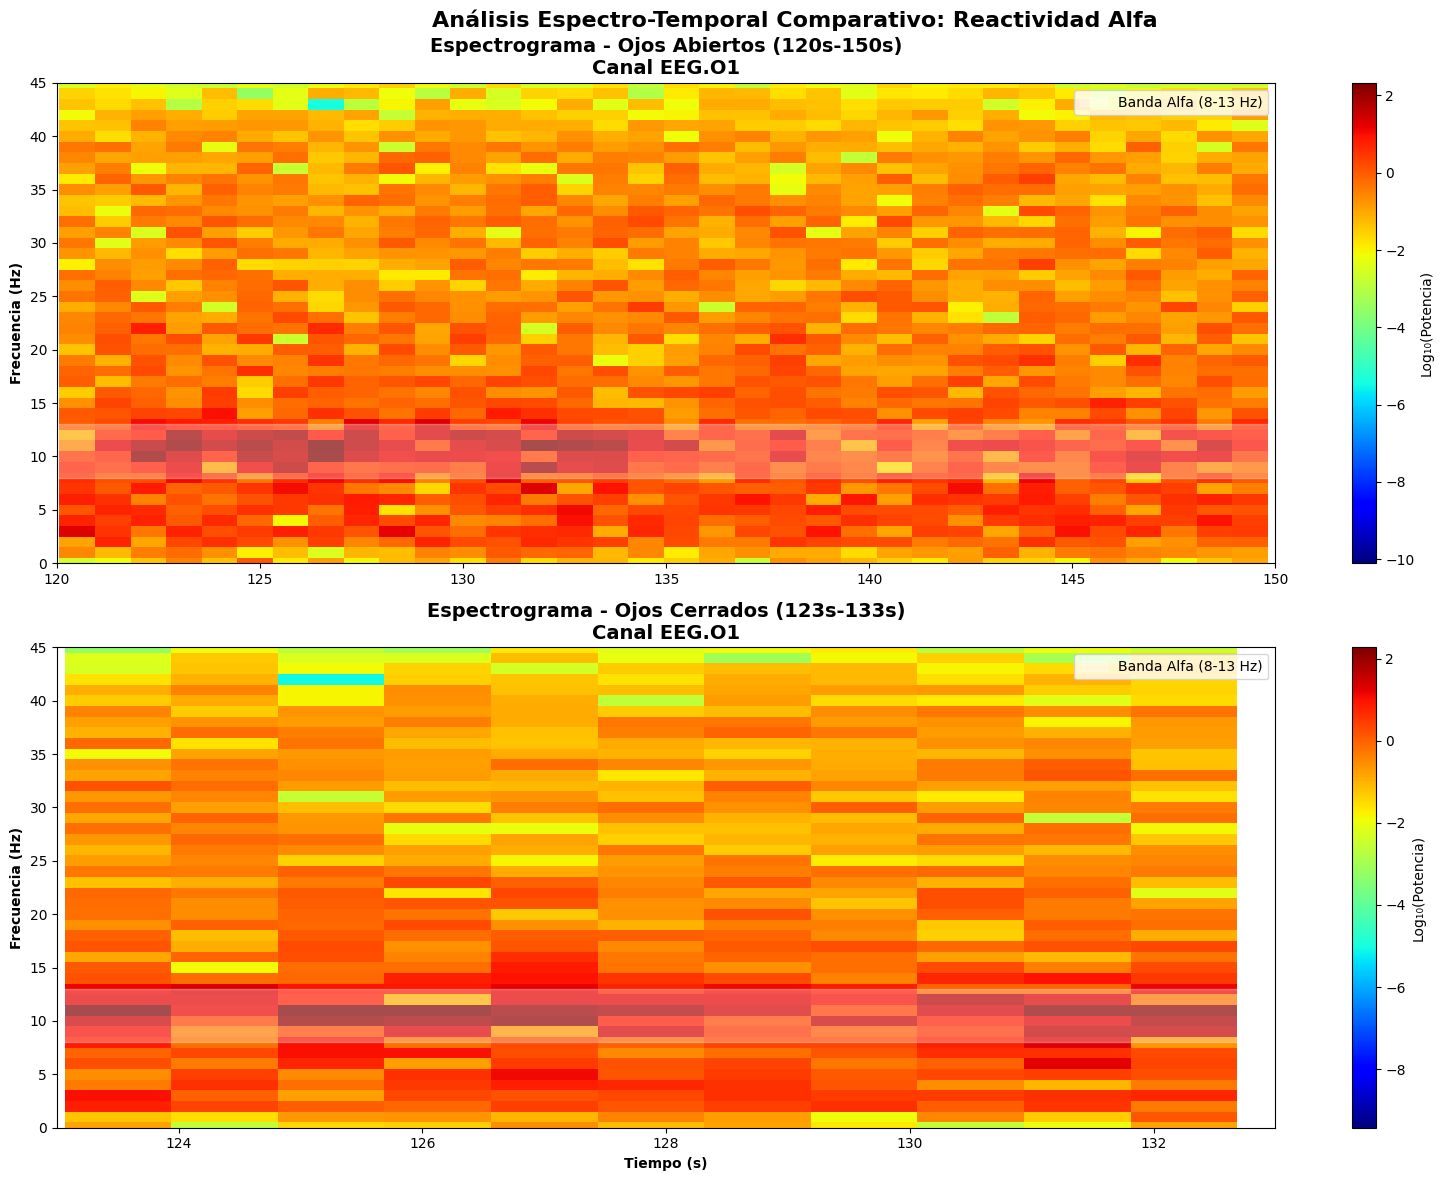

In [8]:
# Crear espectrogramas comparativos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Espectrograma - Ojos Abiertos
f_a, t_a_stft, sxx_a = signal.spectrogram(y_abiertos, fm, nperseg=128, scaling='spectrum')
im1 = ax1.pcolormesh(t_a_stft + ti_a, f_a, np.log10(sxx_a + 1e-12), cmap='jet', shading='auto')
ax1.set_ylabel('Frecuencia (Hz)', fontweight='bold')
ax1.set_title(f'Espectrograma - Ojos Abiertos ({ti_a}s-{tf_a}s)\nCanal {nombres[nc]}', 
              fontweight='bold', fontsize=14)
ax1.set_xlim(ti_a, tf_a)
ax1.set_ylim(0, 45)
plt.colorbar(im1, ax=ax1, label='Log₁₀(Potencia)')

# Destacar banda alfa
ax1.axhspan(8, 13, alpha=0.3, color='white', label='Banda Alfa (8-13 Hz)')
ax1.legend(loc='upper right')

# Espectrograma - Ojos Cerrados
f_c, t_c_stft, sxx_c = signal.spectrogram(y_cerrados, fm, nperseg=128, scaling='spectrum')
im2 = ax2.pcolormesh(t_c_stft + ti_cerrados, f_c, np.log10(sxx_c + 1e-12), cmap='jet', shading='auto')
ax2.set_ylabel('Frecuencia (Hz)', fontweight='bold')
ax2.set_xlabel('Tiempo (s)', fontweight='bold')
ax2.set_title(f'Espectrograma - Ojos Cerrados ({ti_cerrados}s-{tf_cerrados}s)\nCanal {nombres[nc]}', 
              fontweight='bold', fontsize=14)
ax2.set_xlim(ti_cerrados, tf_cerrados)
ax2.set_ylim(0, 45)
plt.colorbar(im2, ax=ax2, label='Log₁₀(Potencia)')

# Destacar banda alfa
ax2.axhspan(8, 13, alpha=0.3, color='white', label='Banda Alfa (8-13 Hz)')
ax2.legend(loc='upper right')

plt.suptitle('Análisis Espectro-Temporal Comparativo: Reactividad Alfa', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.5.2 Interpretación neurofisiológica de los espectrogramas

Los espectrogramas revelan diferencias fundamentales entre las dos condiciones:

**Ojos Abiertos:** La actividad espectral se distribuye de manera relativamente uniforme across frequencies, con mayor energía en frecuencias bajas (1-8 Hz). La banda alfa (8-13 Hz) muestra actividad mínima, consistente con la supresión alfa durante el procesamiento visual activo.

**Ojos Cerrados:** Se observa un marcado incremento en la potencia de la banda alfa, evidenciado por las regiones de alta intensidad (colores cálidos) en el rango 8-13 Hz. Este patrón refleja la sincronización neural característica del estado de reposo visual.

Esta diferencia constituye un biomarcador robusto de la integridad del sistema visual-cortical y se utiliza clínicamente para evaluar la función neural normal (Ramos-Argüelles et al., 2009).


4.6 Ejercicios Exploratorios 
4.E1: Compromiso Tiempo-Frecuencia (Variar nperseg).
4.E2: Ventana y Ponderación (Comparar Hann, Hamming, Blackman, Bartlett).
4.E3: Evolución Temporal Detallada (Revisitar $P_b(t)$ con foco en transiciones si las hubiera o artefactos). (Adaptado del E4 original)
4.E4: Mapa de Energía Relativa por Bandas (Heatmap banda × tiempo). (Adaptado del E5 original)
4.E5: Análisis de otro canal (ej. Frontal Fp1) y comparar espectrograma con O1. (Nuevo ejercicio sugerido)
4.7 Reflexión Final 
Ventajas y limitaciones de la STFT (resolución fija).
Importancia para señales no estacionarias como el EEG.
4.8 Puente Hacia el Análisis Adaptativo 
Limitación de la ventana fija vs. naturaleza del cerebro.
Introducción a Hilbert (fase/amplitud instantánea) y Wavelets (resolución variable).
Conexión con Notebook 5.


## 4.9 Bibliografía

Allen, J. B., & Rabiner, L. R. (1977). A unified approach to short-time Fourier analysis and synthesis. *Proceedings of the IEEE*, 65(11), 1558-1564.

Buzsáki, G., & Draguhn, A. (2004). Neuronal oscillations in cortical networks. *Science*, 304(5679), 1926-1929.

Cohen, M. X. (2019). *Analyzing neural time series data: theory and practice*. MIT Press.

Gabor, D. (1946). Theory of communication. Part 1: The analysis of information. *Journal of the Institution of Electrical Engineers-Part III: Radio and Communication Engineering*, 93(26), 429-441.

Harris, F. J. (1978). On the use of windows for harmonic analysis with the discrete Fourier transform. *Proceedings of the IEEE*, 66(1), 51-83.

Klimesch, W. (2012). Alpha-band oscillations, attention, and controlled access to stored information. *Trends in Cognitive Sciences*, 16(12), 606-617.

Ng, S. C., Raveendran, P., & Dlay, S. (2022). Time-frequency analysis of EEG signals for brain-computer interface applications. In *Handbook of Neural Engineering* (pp. 345-367). Springer.

Oppenheim, A. V., Schafer, R. W., & Buck, J. R. (2010). *Discrete-time signal processing* (3rd ed.). Pearson.

Ramos-Argüelles, F., Morales, G., Egozcue, S., Pabón, R. M., & Alonso, M. T. (2009). Técnicas básicas de electroencefalografía: principios y aplicaciones clínicas. *Anales del Sistema Sanitario de Navarra*, 32(Supl. 3), 69-82.

Sejdić, E., Djurović, I., & Jiang, J. (2009). Time–frequency feature representation using energy concentration: An overview of recent advances. *Digital Signal Processing*, 19(1), 153-173.

Widmann, A., Schröger, E., & Maess, B. (2015). Digital filter design for electrophysiological data–a practical approach. *Journal of Neuroscience Methods*, 250, 34-46.